# Welcome to the Prognostics Model Library Tutorial

The goal of this notebook is to instruct users on how to use and extend the NASA PCoE Python Prognostics Model Package. 

First some background. The Prognostics Model Package is a python package for the modeling and simulation of the evolution of state for physical components, with a focus on simulating specific events. When used for prognostics, these events are typically system failures, such as a winding failure on a motor or full discharge of a battery. 

A few definitions:
* events: some state that can be predicted (e.g., system failure). An event has either occured or not. 
* event state: progress towards event occuring. Defined as a number where an event state of 0 indicates the event has occured and 1 indicates no progress towards the event (i.e., fully healthy operation for a failure event). For gradually occuring events (e.g., discharge) the number will progress from 1 to 0 as the event nears. In prognostics, event state is frequently called "State of Health"
* inputs: control applied to the system being modeled (e.g., current drawn from a battery)
* outputs: measured sensor values from a system (e.g., voltage and temperature of a battery)
* states: Internal parameters (typically hidden states) used to represent the state of the system- can be same as inputs/outputs but do not have to be. 
* process noise: stochastic process representing uncertainty in the model transition. 
* measurement noise: stochastic process representing uncertainty in the measurement process; e.g., sensor sensitivity, sensor misalignements, environmental effects 

The `prog_models` package has the following structure
* `prog_models.PrognosticsModel` - parent class for all prognostics models - defines interfaces that a model must implement, and tools for simulating said model 
* `prog_models.models.*` - implemented models (e.g., pump, valve, battery)

In addition to the `prog_models` package, this repo includes examples showing how to use the package (see `examples/`), a template for implementing a new model (`prog_model_template`), documentation (`docs/`), and this tutorial (`tutorial.ipynb`).

Before you start, make sure that all the required packages are installed (see `requirements.txt`)

Now lets get started with some examples

## Using the included models

This first example is for using the included prognostics models. First thing to do is to import the model you would like to use:

In [1]:
from prog_models.models import BatteryCircuit

This imports the battery_circuit model distributed with the `prog_models` package. 

Next, lets create a new battery using the default settings:

In [2]:
batt = BatteryCircuit()

This creates a battery circuit model. You can also pass configuration parameters into the constructor as kwargs to configure the system, for example
### <center>`BatteryCircuit(process_noise= 0)`</center>

Alternatively, you can set the configuration of the system afterwards, like so:

In [3]:
batt.parameters['process_noise'] = 0 # No process noise

Lets use the member properties to check out some details of the model, first the model configuration:

In [4]:
print('configuration: ', batt.parameters)

configuration:  {'V0': 4.183, 'Rp': 10000.0, 'qMax': 7856.3254, 'CMax': 7777, 'VEOD': 3.0, 'VDropoff': 0.1, 'Cb0': 1878.155726, 'Cbp0': -230, 'Cbp1': 1.2, 'Cbp2': 2079.9, 'Cbp3': 27.055726, 'Rs': 0.0538926, 'Cs': 234.387, 'Rcp0': 0.0697776, 'Rcp1': 1.50528e-17, 'Rcp2': 37.223, 'Ccp': 14.8223, 'Ta': 18.95, 'Jt': 800, 'ha': 0.5, 'hcp': 19, 'hcs': 1, 'x0': {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0, 'qcs': 0}, 'nomCapacity': 2.2, 'CRateMin': 0.7, 'CRateMax': 2.5, 'process_noise': {'tb': 0, 'qb': 0, 'qcp': 0, 'qcs': 0}, 'measurement_noise': {'t': 0.0, 'v': 0.0}}


You can also save or load your model configuration using pickle

In [5]:
import pickle
pickle.dump(batt.parameters, open('ex.pickle', 'wb'))

Then you can set your model configuration like below. This is useful for recording and restoring model configurations

In [6]:
batt.parameters = pickle.load(open('ex.pickle', 'rb'))

Next the expected inputs (loading) and outputs (measurements)

In [7]:
print('inputs: ', batt.inputs)
print('outputs: ', batt.outputs)

inputs:  ['i']
outputs:  ['t', 'v']


Now lets look at what event we're predicting. This model only predicts one event, but that's not true for every model

In [8]:
print('event(s): ', batt.events)

event(s):  ['EOD']


Finally, let's take a look at the internal states that the model uses to represent the system:

In [9]:
print('states: ', batt.states)

states:  ['tb', 'qb', 'qcp', 'qcs']


All those checks were just to take a look at the properties of this model. Now let's work towards simulating. 

Next, we define future loading. This is a function that describes how the system will be loaded as a function of time. Here we're defining a basic peasewise function.

In [10]:
def future_loading(t, x=None):
    # Variable (piece-wise) future loading scheme 
    if (t < 600):
        i = 2
    elif (t < 900):
        i = 1
    elif (t < 1800):
        i = 4
    elif (t < 3000):
        i = 2
    else:
        i = 3
    return {'i': i}

At last it's time to simulate. First we're going to simulate forward 200 seconds. To do this we have to define our first expected output (e.g., measurement) to initialize the model state. Then we're going to use the function simulate_to() to simulate to the specified time and print the results

In [11]:
first_output = {'t': 18.95, 'v': 4.183} # temperature of 18.95, and voltage of 4.183
time_to_simulate_to = 200
sim_config = {
    'save_freq': 20, 
    'print': True  # Print states - Note: is much faster without
}
(times, inputs, states, outputs, event_states) = batt.simulate_to(time_to_simulate_to, future_loading, first_output, **sim_config)

Time: 0.0
	Input: {'i': 2}
	State: {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0, 'qcs': 0}
	Output: {'t': 18.95, 'v': 4.182999999010731}
	Event State: {'EOD': 1.0}

Time: 20.0
	Input: {'i': 2}
	State: {'tb': 19.076442043154504, 'qb': 7816.317409400196, 'qcp': 2.0689378979001236, 'qcs': 20.413263009931665}
	Output: {'t': 19.076442043154504, 'v': 3.9509958120257234}
	Event State: {'EOD': 0.9948556010544164}

Time: 40.0
	Input: {'i': 2}
	State: {'tb': 19.21108882800633, 'qb': 7776.309532730197, 'qcp': 2.0689354655665255, 'qcs': 24.33552624261428}
	Output: {'t': 19.21108882800633, 'v': 3.928972715987753}
	Event State: {'EOD': 0.9897112167584156}

Time: 60.0
	Input: {'i': 2}
	State: {'tb': 19.344849669269525, 'qb': 7736.30168367676, 'qcp': 2.068934560241183, 'qcs': 25.089157461180513}
	Output: {'t': 19.344849669269525, 'v': 3.9205081922612974}
	Event State: {'EOD': 0.9845668360134705}

Time: 80.0
	Input: {'i': 2}
	State: {'tb': 19.47710892441248, 'qb': 7696.293848365142, 'qcp': 2.068933951625493

We can also plot the results

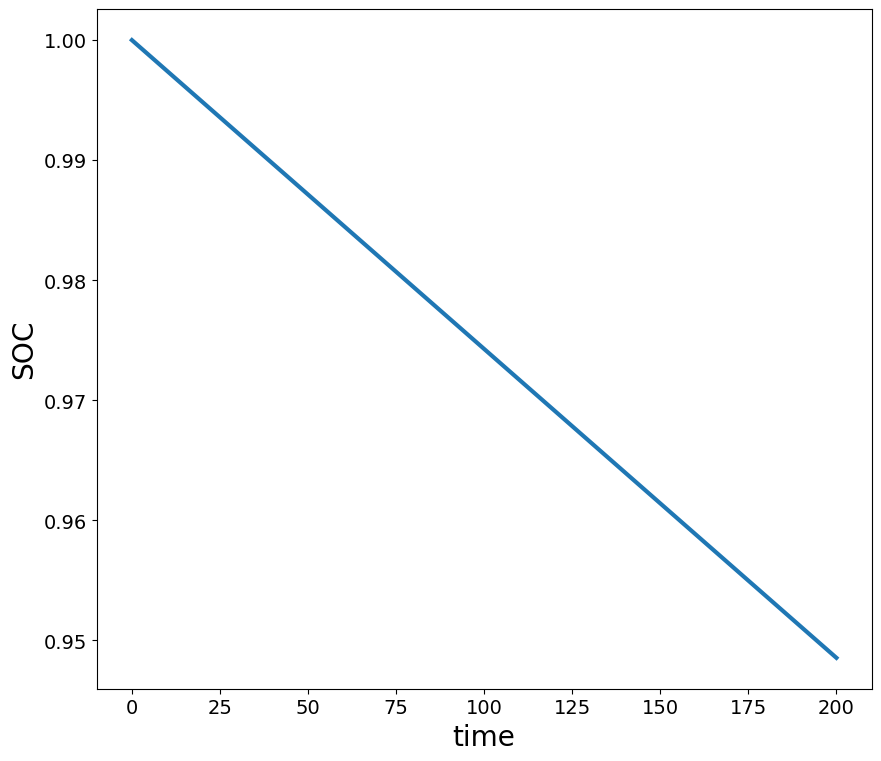

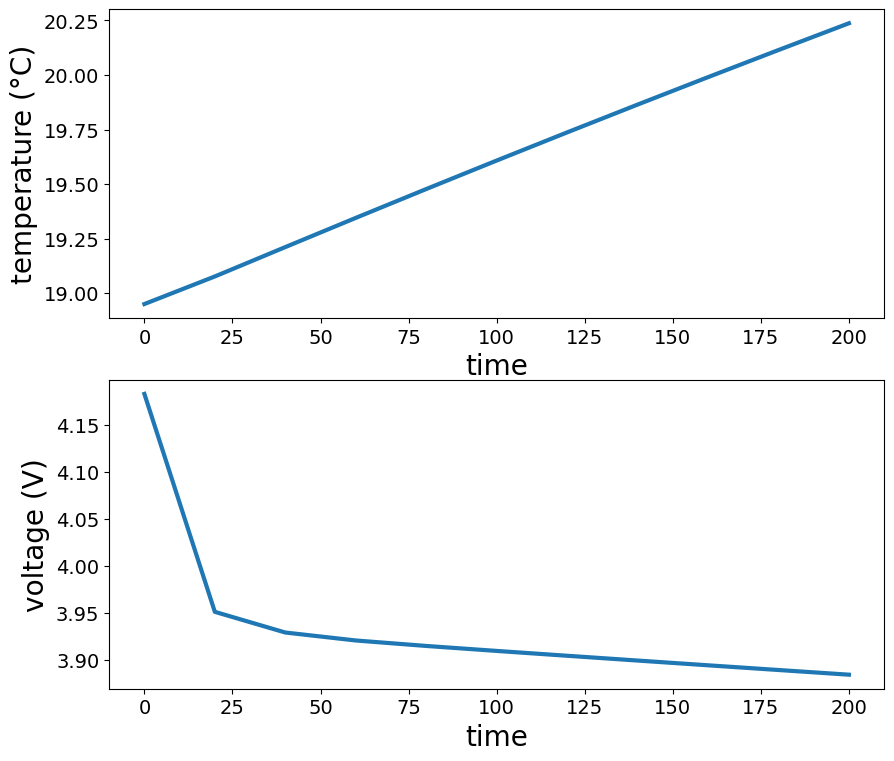

In [12]:
event_states.plot(ylabel= 'SOC')
outputs.plot(ylabel= {'v': "voltage (V)", 't': 'temperature (°C)'}, compact= False)


Instead of specifying a specific amount of time, we can also simulate until a threshold has been met using the simulate_to_threshold() method




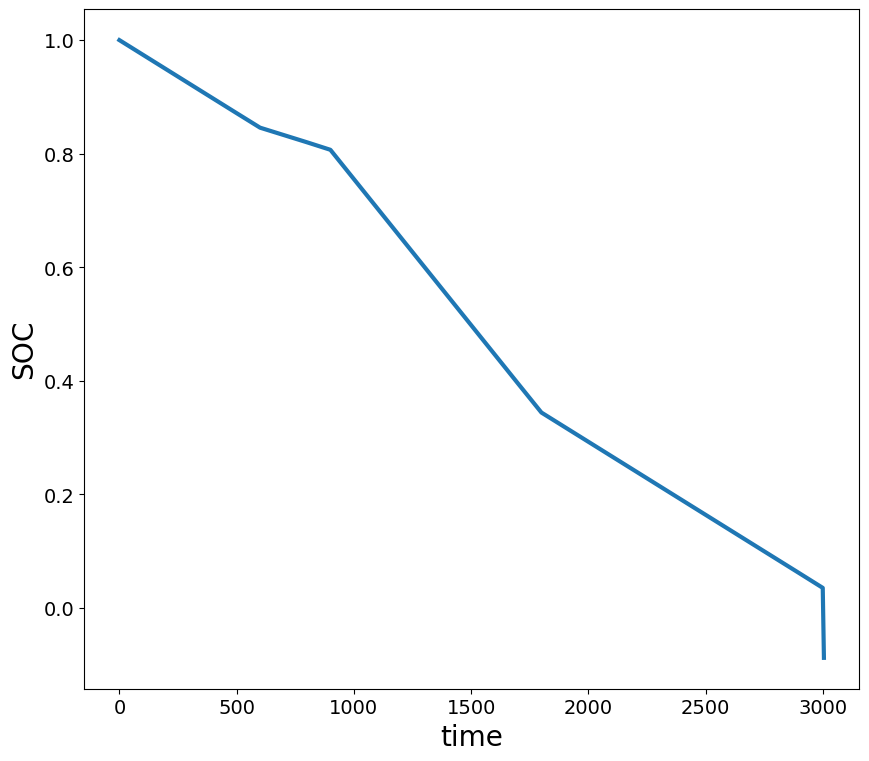

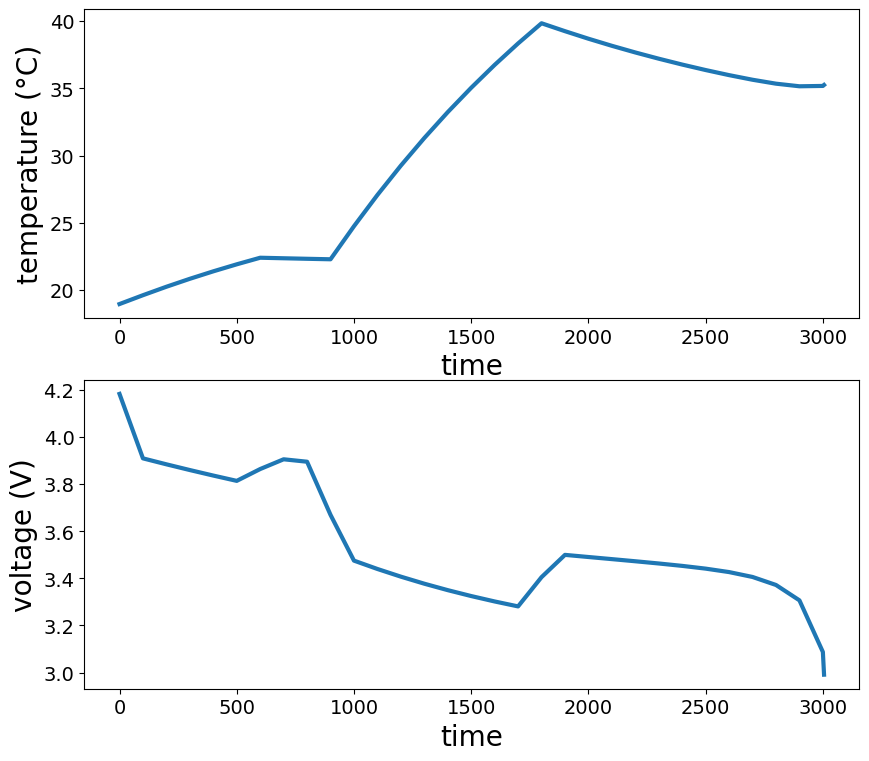

In [13]:
options = { #configuration for this sim
    'save_freq': 100, # Frequency at which results are saved (s)
    'horizon': 5000 # Maximum time to simulate (s) - This is a cutoff. The simulation will end at this time, or when a threshold has been met, whichever is first
    }
(times, inputs, states, outputs, event_states) = batt.simulate_to_threshold(future_loading, {'t': 18.95, 'v': 4.183}, **options)
event_states.plot(ylabel='SOC')
outputs.plot(ylabel= {'v': "voltage (V)", 't': 'temperature (°C)'}, compact= False)

Default is to simulate until any threshold is met, but we can also specify which event we are simulating to (any key from model.events) for multiple event models. 

## Building a new model using model generation
The easiest way to build a new model is by using the model generation feature. This works for simple models.

For this example, let's use a model of throwing an object directly into the air in a vacuum.

First lets describe the model in a dictionary:

In [14]:
keys = {
    'inputs': [], # no inputs, no way to control
    'states': [
        'x', # Position (m) 
        'v'  # Velocity (m/s)
    ],
    'outputs': [ # Anything we can measure
        'x' # Position (m)
    ],
    'events': [
        'falling', # Event- object is falling
        'impact' # Event- object has impacted the ground
    ]
}

Here we have a description of what we're going to try to model, including any inputs, states, outputs, and predicted events. Now we can start defining the details of the model logic.

First, we're going to define the initialization function. This is used to generate the first state.

In [15]:
thrower_height = 1.83 # m
throwing_speed = 40 # m/s
def initialize(u, z):
    return {
        'x': thrower_height, # Thrown, so initial altitude is height of thrower
        'v': throwing_speed # Velocity at which the ball is thrown - this guy is an professional baseball pitcher
        }

Next, lets define the output equation- this translates from the state to any measurable parameters. In this case it's simple since we're saying the position ('x') state is directly measureable.

In [16]:
def output(x):
    return {
        'x': x['x']
    }

Now, let's define the threshold_met and event_state equations. This defines when each event has occured, and how close you are to the event occuring, respectively. 

In [17]:
def threshold_met(x):
    return {
        'falling': x['v'] < 0,
        'impact': x['x'] <= 0
    }

def event_state(x): 
    event_state.max_x = max(event_state.max_x, x['x']) # Maximum altitude
    return {
        'falling': max(x['v']/throwing_speed,0), # Throwing speed is max speed
        'impact': (x['v'] > 0) or max(x['x']/event_state.max_x,0) # 1 until falling begins, then it's fraction of height
    }
event_state.max_x = 0

Note: strictly speaking the threshold_met equation isn't needed here- the default behavior is that the threshold is met when event state reaches 0. We define it here, because this implementation is more efficient. 

Finally, we define the meat of the model. There are two types of models: continuous and discrete. Discrete models are defined by some sort of transition equation x' = next_state(x, u, dt) while continuous models can be defined by the first derivative dx = dx(x, u). This model is continuous, so we define the equation dx:

In [18]:
def dx(x, u):
    return {
        'x': x['v'],
        'v': -9.81 # Acceleration of gravity
    }

Now we have all our pieces and can put it all together

In [19]:
from prog_models import PrognosticsModel
m = PrognosticsModel.generate_model(keys, initialize, output, event_state_eqn = event_state, threshold_eqn=threshold_met, dx_eqn=dx)

Now that we have our model `m` we can use it just like the model in our previous example. 

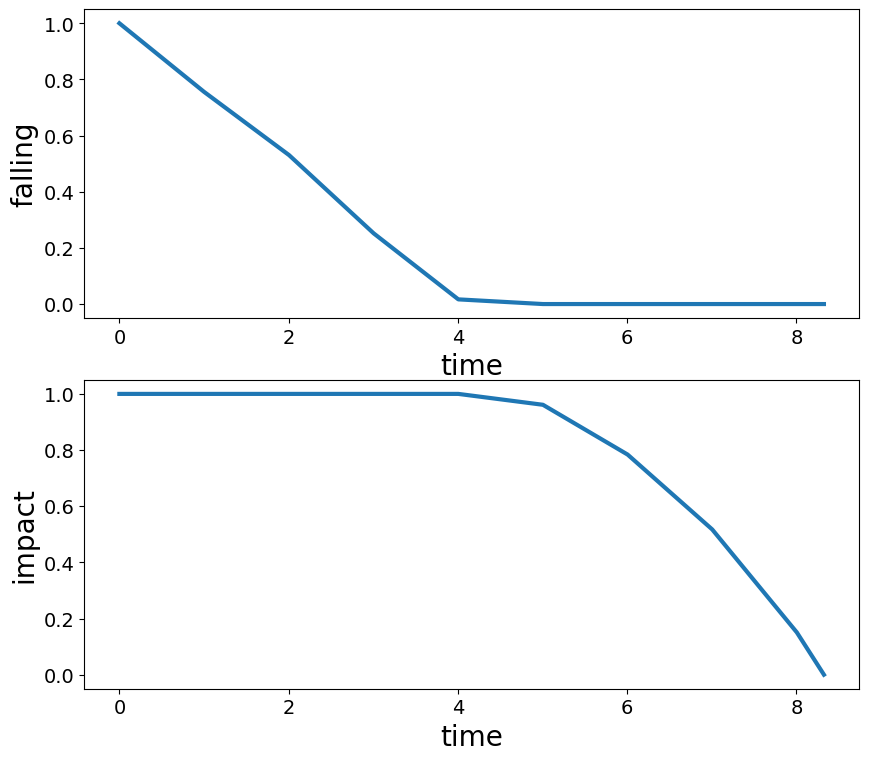

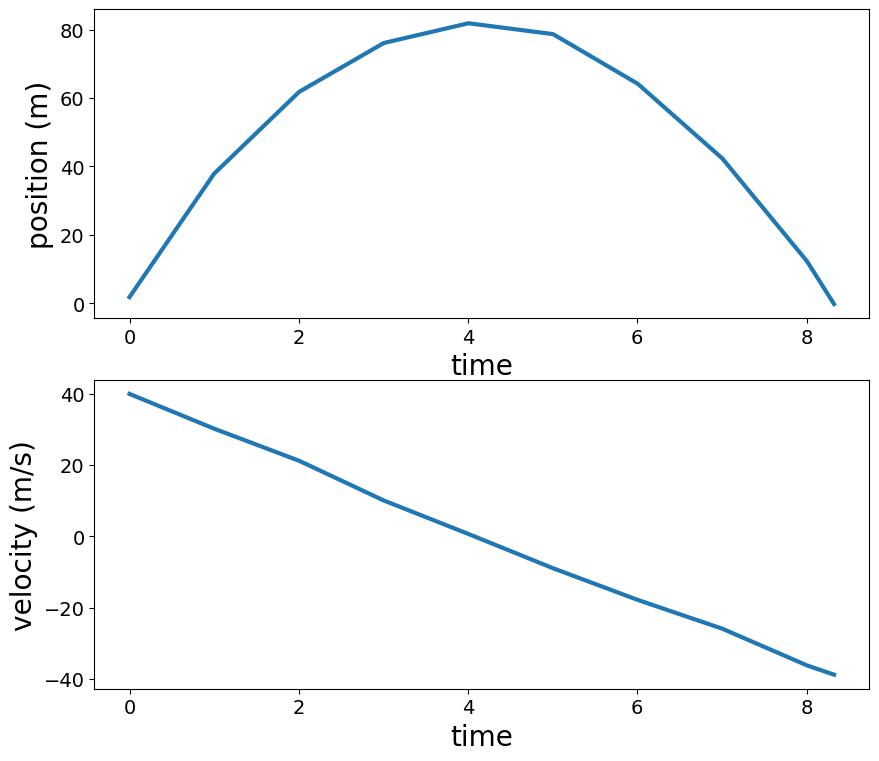

In [20]:
def future_load(t, x=None):
        return {} # No loading
event = 'impact'

(times, inputs, states, outputs, event_states) = m.simulate_to_threshold(future_load, {'x':thrower_height}, threshold_keys=[event], dt=0.005, save_freq=1)

event_states.plot(ylabel= ['falling', 'impact'], compact= False)
states.plot(ylabel= {'x': "position (m)", 'v': 'velocity (m/s)'}, compact= False)

## Building a new model - advanced
For more advanced models, you can create a seperate class to defin the logic of the model. The functions are the same, just in a different format, and with added parameters. The model above could be defined using this approach like so:


In [21]:
from prog_models import PrognosticsModel

# Model used in example
class ThrownObject(PrognosticsModel):
    """
    Model that similates an object thrown into the air without air resistance
    """

    inputs = [] # no inputs, no way to control
    states = [
        'x', # Position (m) 
        'v'  # Velocity (m/s)
        ]
    outputs = [ # Anything we can measure
        'x' # Position (m)
    ]
    events = [
        'falling', # Event- object is falling
        'impact' # Event- object has impacted ground
    ]

    # The Default parameters. Overwritten by passing parameters dictionary into constructor
    default_parameters = {
        'thrower_height': 1.83, # m
        'throwing_speed': 40, # m/s
        'g': -9.81, # Acceleration due to gravity in m/s^2
        'process_noise': 0.0 # amount of noise in each step
    }

    def initialize(self, u, z):
        self.max_x = 0.0
        return {
            'x': self.parameters['thrower_height'], # Thrown, so initial altitude is height of thrower
            'v': self.parameters['throwing_speed'] # Velocity at which the ball is thrown - this guy is an professional baseball pitcher
            }
    
    def dx(self, x, u):
        # apply_process_noise is used to add process noise to each step
        return {
            'x': x['v'],
            'v': self.parameters['g'] # Acceleration of gravity
        }

    def output(self, x):
        return {
            'x': x['x']
        }

    # This is actually optional. Leaving thresholds_met empty will use the event state to define thresholds.
    #  Threshold = Event State == 0. However, this implementation is more efficient, so we included it
    def threshold_met(self, x):
        return {
            'falling': x['v'] < 0,
            'impact': x['x'] <= 0
        }

    def event_state(self, x): 
        self.max_x = max(self.max_x, x['x']) # Maximum altitude
        return {
            'falling': max(x['v']/self.parameters['throwing_speed'],0), # Throwing speed is max speed
            'impact': (x['v'] > 0) or max(x['x']/self.max_x,0) # 1 until falling begins, then it's fraction of height
        }

Now the model can be generated and used like any of the other provided models

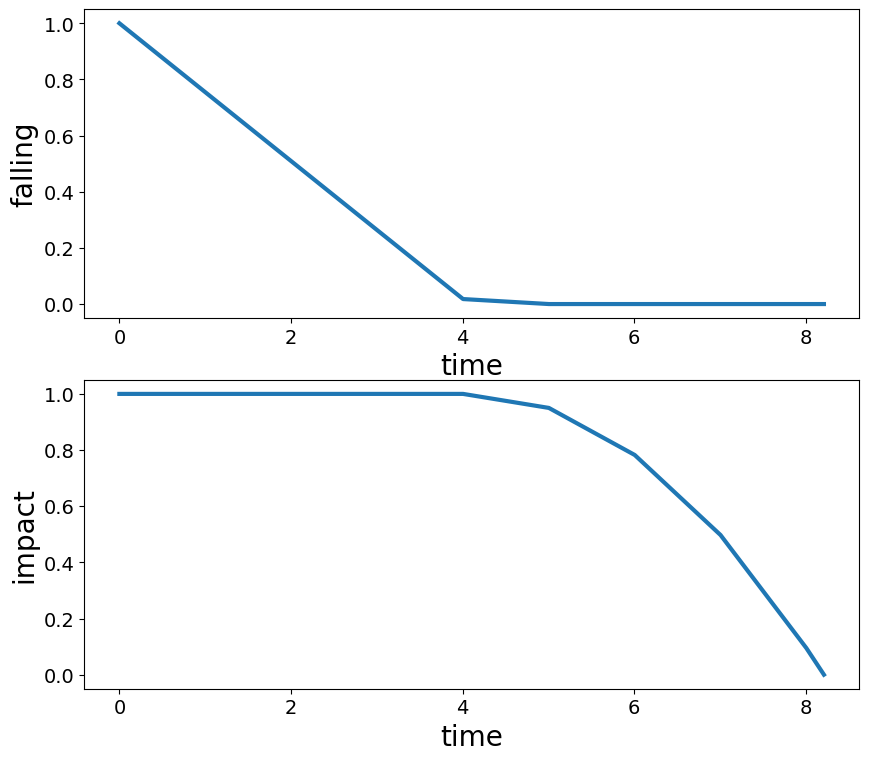

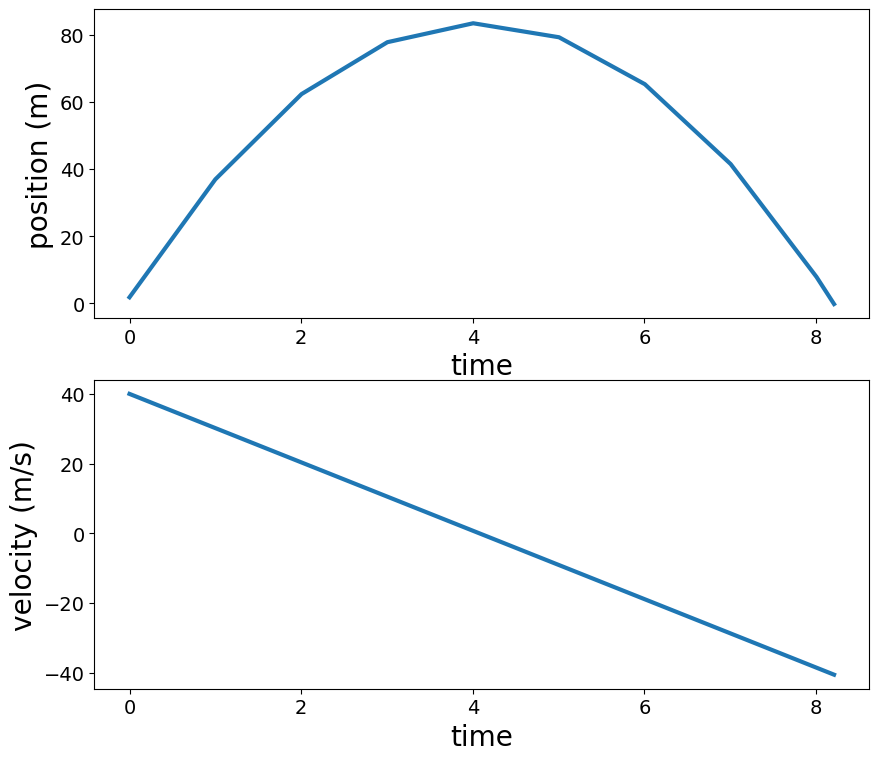

In [22]:
m = ThrownObject()

def future_load(t, x=None):
        return {} # No loading
event = 'impact'

(times, inputs, states, outputs, event_states) = m.simulate_to_threshold(future_load, {'x':m.parameters['thrower_height']}, threshold_keys=[event], dt=0.005, save_freq=1)

event_states.plot(ylabel= ['falling', 'impact'], compact= False)
states.plot(ylabel= {'x': "position (m)", 'v': 'velocity (m/s)'}, compact= False)

Models can also include "derived parameters" (i.e., parameters that are derived from others). These can be set using the param_callbacks property. 

Let's extend the above model to include derived_parameters. Let's say that the throwing_speed was actually a function of thrower_height (i.e., a taller thrower would throw the ball faster). Here's how we would implement that

In [23]:
# Step 1: Define a function for the relationship between thrower_height and throwing_speed.
def update_thrown_speed(params):
    return {
        'throwing_speed': params['thrower_height'] * 21.85
    }  # Assumes thrown_speed is linear function of height

# Step 2: Define the param callbacks
ThrownObject.param_callbacks = {
        'thrower_height': [update_thrown_speed]
    }  # Tell the derived callbacks feature to call this function when thrower_height changes.

Note: Usually we would define this menthod within the class. For this example, we're doing it separately to improve readability. Here's the feature in action

In [24]:
obj = ThrownObject()
print("Default Settings:\n\tthrower_height: {}\n\tthowing_speed: {}".format(obj.parameters['thrower_height'], obj.parameters['throwing_speed']))

# Now let's change the thrower_height
print("changing height...")
obj.parameters['thrower_height'] = 1.75  # Our thrower is 1.75 m tall
print("\nUpdated Settings:\n\tthrower_height: {}\n\tthowing_speed: {}".format(obj.parameters['thrower_height'], obj.parameters['throwing_speed']))
print("Notice how speed changed automatically with height")

# Let's delete the callback so we can use the same model in the future:
ThrownObject.param_callbacks = {}

Default Settings:
	thrower_height: 1.83
	thowing_speed: 39.9855
changing height...

Updated Settings:
	thrower_height: 1.75
	thowing_speed: 38.237500000000004
Notice how speed changed automatically with height


# Parameter Estimation
Let's say we dont know the configuration of the above model. Instead, we have some data. We can use that data to estimate the parameters. 

First, we define the data:

In [25]:
times = [0, 1, 2, 3, 4, 5, 6, 7, 8]
inputs = [{}]*9
outputs = [
    {'x': 1.83},
    {'x': 36.95},
    {'x': 62.36},
    {'x': 77.81},
    {'x': 83.45},
    {'x': 79.28},
    {'x': 65.3},
    {'x': 41.51},
    {'x': 7.91},
]

Next, we identify which parameters will be optimized

In [26]:
keys = ['thrower_height', 'throwing_speed']

Let's say we have a first guess that the thrower's height is 20m, silly I know

In [27]:
m.parameters['thrower_height'] = 20

Here's the state of our estimation with that assumption:

In [28]:
print('Model configuration before')
for key in keys:
    print("-", key, m.parameters[key])
print(' Error: ', m.calc_error(times, inputs, outputs, dt=1e-4))

Model configuration before
- thrower_height 20
- throwing_speed 40
 Error:  2952.0504278242124


Wow, that's a large error. 

Let's run the parameter estimation to see if we can do better

In [29]:
m.estimate_params([(times, inputs, outputs)], keys, dt=0.01)

# Print result
print('\nOptimized configuration')
for key in keys:
    print("-", key, m.parameters[key])
print(' Error: ', m.calc_error(times, inputs, outputs, dt=1e-4))


Optimized configuration
- thrower_height 1.9077778305977766
- throwing_speed 39.94678332760985
 Error:  0.5038842595563968


Much better!

## Conclusion
Thank you for trying out this tutorial. See the examples in the `examples/` folder for more details on how to use the package. Any questions can be directed to Chris Teubert (christopher.a.teubert@nasa.gov)